In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import scipy
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import tushare as ts
import scipy.stats as stats

In [2]:
# tushare is a Chinese stock market data API. 
# It is free to download shares' daily data in Chinese Market.
# I hope this API works well. 
# If anything wrong with this package and you cannot get the data,
# please contact us.

import tushare as ts
pro = ts.pro_api('6278bfee192fcc3496a2789689930a63f3dd2027811b101933ee2064')

In [3]:
def calc_beta_r2(highs, lows):
    
    xx = sm.add_constant(lows)  # add a constant for X
    model = sm.OLS(highs, xx).fit()  
    beta = model.params[1]  # model.params.low
    r2 = model.rsquared
    
    return beta, r2

In [4]:
def calc_beta_r2_w(highs, lows, volumes):

    # The weights of volumes
    weights = volumes / volumes.sum()

    xx = sm.add_constant(lows)  # add a constant for X
    model = sm.WLS(highs, xx, weights).fit()  # sm.WLS(y, X, weights)
    beta = model.params[1]  # model.params.low
    r2 = model.rsquared
    return beta, r2

In [5]:
# Simplest RSRS Index, without M.
def calcRSRS_simple(df_price, N):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''

    _h = (df_price["high"] - df_price["high"].mean()) / df_price["high"].std()
    _l = (df_price["low"] - df_price["low"].mean()) / df_price["low"].std()

    _N = N

    RSRS = []

    for i in range(len(_h))[_N:]:
        data_high = _h.iloc[i - _N + 1: i + 1]
        data_low = _l.iloc[i - _N + 1: i + 1]
        
        _X_ols = sm.add_constant(data_low)
        model = sm.OLS(data_high, _X_ols)
        results = model.fit()
        RSRS.append(results.params.low)

    return RSRS

In [6]:
# Initial RSRS Index
def calcRSRS(df_price, N, M):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''
    # Intermediate Variables
    RSRS = []
    beta_weight = []
    r2_weight = []
    
    # Store data
    _h = df_price.high.values
    _l = df_price.low.values
    
    # Compute and store the list of beta and r2
    for i in range(0, len(_h) - N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)
        
    # Compute the RSRS index    
    for i in range(0, len(_h)- N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)        
        
    # Take the time series of beta in the previous M days and calculate the z_score standard score      
        section = beta_weight[-M:]
        mu = np.mean(section)
        sigma = np.std(section)
        z_score = (section[-1] - mu) / sigma
        
        
        rsrs = z_score * r2
        
        RSRS.append(rsrs)
        
        
    return RSRS

In [7]:
# Improvment method 1 
# Change the RSRS index according to the weights of volume

def calcRSRS_w(df_price, N, M):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''
    # Intermediate Variables
    RSRS_w = []
    beta_weight = []
    r2_weight = []
    
    # Store data
    _h = df_price.high.values
    _l = df_price.low.values
    _v = df_price.vol.values
    
    
    # Compute and store the list of beta and r2
    for i in range(0, len(_h) - N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2_w(highs, lows, volumes)
        
        beta_weight.append(beta)
        r2_weight.append(r2)
        
    # Compute the reviesed RSRS index (Change the index according to to weights of volume)
    for i in range(0, len(_h)- N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2_w(highs, lows, volumes)
        
        beta_weight.append(beta)
        r2_weight.append(r2)        
        
    # Take the time series of beta in the previous M days and calculate the z_score standard score        
        section = beta_weight[-M:]
        mu = np.mean(section)
        sigma = np.std(section)
        z_score = (section[-1] - mu) / sigma
        
        
        rsrs_w = z_score * r2
        
        RSRS_w.append(rsrs_w)
        
        
    return RSRS_w

In [8]:
# Improvment method 2
# Passivate the RSRS index 

def calcRSRS_passi(df_price, N, M):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''
    # Intermediate Variables
    RSRS_passi = []
    volatility = []
    beta_weight = []
    r2_weight = []
    
    # Store data
    _h = df_price.high.values
    _l = df_price.low.values
    _v = df_price.vol.values
    
    # Compute and store the daily_return and volatility
    daily_return = df_price.open.pct_change()[1:].values
    for i in range(0, len(daily_return) - N + 1):
        std = np.std(daily_return[i:i + N])
        volatility.append(std)
    
    # Compute and store the list of beta and r2
    for i in range(0, len(_h) - N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)
        
    # Compute the passivated RSRS index    
    for i in range(0, len(_h)- N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2(highs, lows)
        
        beta_weight.append(beta)
        r2_weight.append(r2)        
        
    # Take the time series of beta in the previous M days and calculate the z_score standard score          
        section = beta_weight[-M:]
        mu = np.mean(section)
        sigma = np.std(section)
        z_score = (section[-1] - mu) / sigma
        
        
    # Compute the standard error of the last N days
        daily_return = df_price.open.pct_change()[1:].values[i: i + N]
        std = np.std(daily_return)
        volatility.append(std)
        
    # Calculate the percentile of the previous standard deviation in the past M days
        std_percent = stats.percentileofscore(volatility[-M:], std) / 100
        
        rsrs_passi = z_score * (r2 ** (2 * std_percent))
        
        RSRS_passi.append(rsrs_passi)
        
        
    return RSRS_passi

In [9]:
# Improvement method 3
# Combing the two previous method, we construct a passivated RSRS index which is weighted by the volumes.
def calcRSRS_w_passi(df_price, N, M):
    '''
    INPUT：
    df_price: pandas DataFrame，the daily freq stock price dataframe
        df_price["high"]: the high price of the stock in that day
        df_price["low"]: the low price of the stock in that day
    N: int，the N parameter in model.
    M: int，the M parameter in model.

    OUTPUT：
    RSRS: list[float]，RSRS data
    '''
    # Intermediate Variables
    RSRS_w_passi = []
    volatility = []
    beta_weight = []
    r2_weight = []
    
    # Store data
    _h = df_price.high.values
    _l = df_price.low.values
    _v = df_price.vol.values
    
    # Compute and store the daily_return and volatility
    daily_return = df_price.open.pct_change()[1:].values
    for i in range(0, len(daily_return) - N + 1):
        std = np.std(daily_return[i:i + N])
        volatility.append(std)
    
    # Compute and store the list of beta and r2
    for i in range(0, len(_h) - N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2_w(highs, lows, volumes)
        
        beta_weight.append(beta)
        r2_weight.append(r2)
        
    # Compute the weighted and passivated RSRS index    
    for i in range(0, len(_h)- N + 1):
        highs = _h[i : i + N]
        lows = _l[i : i + N]
        volumes = _v[i : i + N]
        
        beta, r2 = calc_beta_r2_w(highs, lows, volumes)
        
        beta_weight.append(beta)
        r2_weight.append(r2)        
        
    # Take the time series of beta in the previous M days and calculate the z_score standard score          
        section = beta_weight[-M:]
        mu = np.mean(section)
        sigma = np.std(section)
        z_score = (section[-1] - mu) / sigma
        
        
    # Compute the standard error of the last N days
        daily_return = df_price.open.pct_change()[1:].values[i: i + N]
        std = np.std(daily_return)
        volatility.append(std)
        
    
        std_percent = stats.percentileofscore(volatility[-M:], std) / 100
        
        rsrs_w_passi = z_score * (r2 ** (2 * std_percent))
        
        RSRS_w_passi.append(rsrs_w_passi)
        
        
    return RSRS_w_passi

In [10]:
# Maximize Drawback Rate
def maxDrawbackRate(prices) -> float:
    '''
    INPUT：
    prices: np.array object. I'm not sure list and tuple will work or not.

    OUTPUT：
    rt: float，the max drawback rate for given data.
    '''
    prices = [-p for p in prices]
    inf = int(2 << 10)
    minprice = inf
    maxprofit = 0
    for price in prices:
        maxprofit = max(price - minprice, maxprofit)
        minprice = min(price, minprice)
    return maxprofit / minprice

In [11]:
# RSRS Statistics Display
df_ori = pro.daily(ts_code='000001.SZ', start_date='20000101', end_date='20201231')
# df_ori = pro.daily(ts_code='000100.SZ', start_date='20100101', end_date='20201231')

df_ori = sqldf(
    """
    SELECT
        *
    FROM
        df_ori
    ORDER BY
        trade_date ASC
    """
)

In [12]:
# Simplest RSRS Approach
rsrs_s = calcRSRS_simple(df_ori, N=18)
rsrs_s = np.array(rsrs_s)

In [13]:
# rsrs_s.shape
# rsrs.shape

In [14]:
thre_long = 1
thre_short = 0.8

_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

base_position = virtual_initial_cash / df_ori["open"][18]
# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list_s = []
_base_value = []

for i in range(len(rsrs_s)):
    _p = df_ori["open"][17 + i]
    
    if rsrs_s[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
        
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
        
    if rsrs_s[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list_s.append(_today_value)
    _base_value.append(base_position * _p)

In [15]:
# Initial RSRS strategy Sigma Approach
rsrs = calcRSRS(df_ori, N=18, M=600)
rsrs = np.array(rsrs)

In [16]:
thre_long = rsrs.mean() + 1 * rsrs.std()
thre_short = rsrs.mean() - 1 * rsrs.std()

In [17]:
# Strategy Construction
_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

base_position = virtual_initial_cash / df_ori["open"][18]
# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list = []
_base_value = []


for i in range(len(rsrs)):
    _p = df_ori["open"][17 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
    
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list.append(_today_value)
    _base_value.append(base_position * _p)

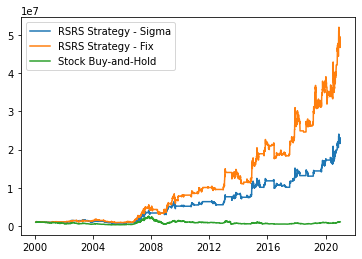

In [18]:
x = pd.to_datetime(df_ori.trade_date)[17:]
plt.plot(x, _value_list, label="RSRS Strategy - Sigma")
plt.plot(x[1:], _value_list_s, label="RSRS Strategy - Fix")
plt.plot(x, _base_value, label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [19]:
cur_value = _value_list[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 23065175.0
Long time: 55
Short time: 55


In [20]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return

0.3301639071674858

In [21]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1

# tracking error
track_err = np.array([(_value_list[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list))]).std()
track_err

5.310932744878423

In [24]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.06104989900290666

In [25]:
maxDrawbackRate(_value_list)

-0.16091223786938835

In [20]:
# Improvement Method 1
# Weighted RSRS strategy
rsrs = calcRSRS_w(df_ori, N=18, M=600)
rsrs = np.array(rsrs)

In [21]:
thre_long = rsrs.mean() + 1 * rsrs.std()
thre_short = rsrs.mean() - 1 * rsrs.std()

In [22]:
# Strategy Construction
_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

base_position = virtual_initial_cash / df_ori["open"][18]
# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list_w = []
_base_value = []


for i in range(len(rsrs)):
    _p = df_ori["open"][17 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
    
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list_w.append(_today_value)
    _base_value.append(base_position * _p)

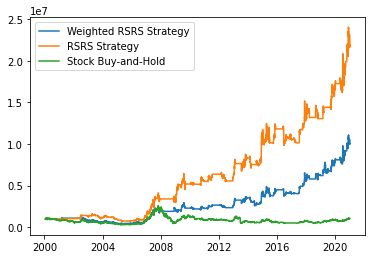

In [23]:
x = pd.to_datetime(df_ori.trade_date)[17:]
plt.plot(x, _value_list_w, label="Weighted RSRS Strategy")
plt.plot(x, _value_list, label="RSRS Strategy")
plt.plot(x, _base_value, label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [24]:
cur_value = _value_list_w[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 10513710.0
Long time: 61
Short time: 61


In [25]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return

0.2384740424745868

In [26]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1

# tracking error
track_err = np.array([(_value_list_w[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list_w))]).std()
track_err

2.273384256923645

In [27]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.10228892994439738

In [28]:
maxDrawbackRate(_value_list)

-0.16091223786938835

In [29]:
# Improvement Method 2
# Passivated RSRS strategy
rsrs = calcRSRS_passi(df_ori, N=18, M=600)
rsrs = np.array(rsrs)

In [30]:
thre_long = rsrs.mean() + 1 * rsrs.std()
thre_short = rsrs.mean() - 1 * rsrs.std()

In [31]:
# Strategy Construction
_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

base_position = virtual_initial_cash / df_ori["open"][18]
# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list_passi = []
_base_value = []


for i in range(len(rsrs)):
    _p = df_ori["open"][17 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
    
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list_passi.append(_today_value)
    _base_value.append(base_position * _p)

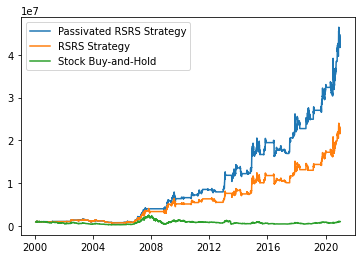

In [32]:
x = pd.to_datetime(df_ori.trade_date)[17:]
plt.plot(x, _value_list_passi, label="Passivated RSRS Strategy")
plt.plot(x, _value_list, label="RSRS Strategy")
plt.plot(x, _base_value, label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [33]:
cur_value = _value_list_passi[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 44593217.0
Long time: 53
Short time: 53


In [34]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return

0.4123213605874323

In [35]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1

# tracking error
track_err = np.array([(_value_list_passi[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list_passi))]).std()
track_err

10.152731872096862

In [36]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.040027587276573254

In [37]:
maxDrawbackRate(_value_list_passi)

-0.15628503076784298

In [84]:
# Improvement Method 3
# Passivated RSRS strategy (Weighted by volumes)
rsrs = calcRSRS_w_passi(df_ori, N=18, M=600)
rsrs = np.array(rsrs)

In [85]:
thre_long = rsrs.mean() + 1 * rsrs.std()
thre_short = rsrs.mean() - 1 * rsrs.std()

In [86]:
# Strategy Construction
_is_hold = False
virtual_initial_cash = 1000000
virtual_cash = virtual_initial_cash
virtual_position = 0
virtual_value = virtual_initial_cash + 0
# Explanation: value = cash + stock = cash + position * price

base_position = virtual_initial_cash / df_ori["open"][18]
# base: simply buy and hold the stock.

ct_long = 0
ct_short = 0


_value_list_w_passi = []
_base_value = []


for i in range(len(rsrs)):
    _p = df_ori["open"][17 + i]
    
    if rsrs[i] >= thre_long and _is_hold == False:
        _is_hold = True
        ct_long += 1
    
        virtual_position = 100 * int(virtual_cash / (_p * 100))
        virtual_cash -= (virtual_position * _p) 
        
    if rsrs[i] <= thre_short and _is_hold:
        _is_hold = False
        ct_short += 1
        
        virtual_cash += (virtual_position * _p)
        virtual_position = 0
        
    _today_value = virtual_cash + virtual_position * _p
    _value_list_w_passi.append(_today_value)
    _base_value.append(base_position * _p)

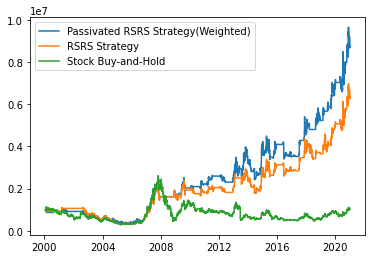

In [89]:
x = pd.to_datetime(df_ori.trade_date)[17:]
plt.plot(x, _value_list_w_passi, label="Passivated RSRS Strategy(Weighted)")
plt.plot(x, _value_list, label="RSRS Strategy")
plt.plot(x, _base_value, label="Stock Buy-and-Hold")
plt.legend(loc='upper left')

In [95]:
cur_value = _value_list_w_passi[-1]

print("Recent value of portfolio:", cur_value)
print("Long time:", ct_long)
print("Short time:", ct_short)

Recent value of portfolio: 9162120.0
Long time: 55
Short time: 55


In [96]:
# annual return
_gain = (cur_value - virtual_value) / virtual_value
annual_return = pow((1 + _gain), (1 / 11)) - 1
annual_return

0.22307807094011145

In [98]:
_base_gain = (_base_value[-1] - virtual_initial_cash) / virtual_initial_cash
annual_return_base = pow((1 + _base_gain), (1 / 11)) - 1

# tracking error
track_err = np.array([(_value_list_w_passi[i] - _base_value[i]) / virtual_initial_cash
                      for i in range(len(_value_list_w_passi))]).std()
track_err

1.9694804239883061

In [99]:
# information ratio
info_ratio = (annual_return - annual_return_base) / track_err
info_ratio

0.11025551146070826

In [100]:
maxDrawbackRate(_value_list_w_passi)

-0.16320735935763225